# Trajectory Optimization for a Cart-Pole System using Casadi

# **Problem Statement**

Cart-Pole system: is a cart that travels along a horizontal rail, and it's powered by a motor that can apply a force along the rail. from the cart you can see a pendulum that can swing freely. 

The swing up problem for a cart-pole system is to find the force as a function of time that will move the cart and have this pendulum which has no motor actuated on it, swing up to be balanced above the cart.

>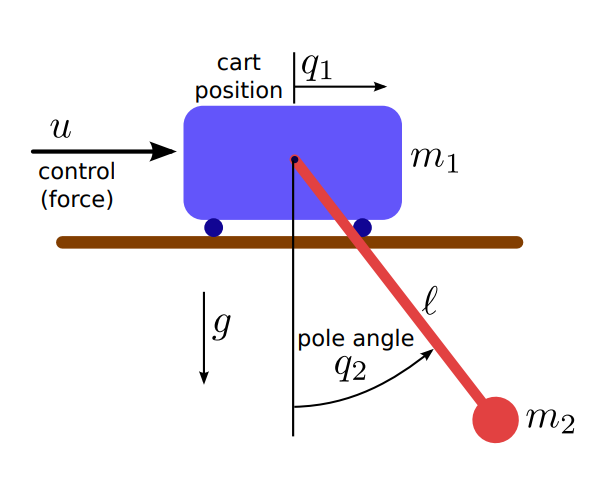



# **System Dynamics**


>\begin{equation}
 \mathbf{D}(\mathbf{q})\ddot{\mathbf{q}} + \mathbf{C}(\mathbf{q},\dot{\mathbf{q}})\dot{\mathbf{q}} + \mathbf{g}(\mathbf{q})  = \mathbf{D}(\mathbf{q})\ddot{\mathbf{q}} + \mathbf{h}(\mathbf{q},\dot{\mathbf{q}}) = \mathbf{B} \mathbf{u}
\end{equation}
>

Where:
\begin{equation}
\mathbf{q}
=
\begin{bmatrix}
x \\
θ
\end{bmatrix}
,
\mathbf{\dot{q}}
=
\begin{bmatrix}
\dot{x} \\
\dot{θ}
\end{bmatrix}
,
\mathbf{\ddot{q}}
=
\begin{bmatrix}
\ddot{x} \\
\ddot{θ}
\end{bmatrix}
\end{equation}


\begin{equation}
\begin{bmatrix}
m_1 + m_2  &  m_2 L \cos(\theta)\\
m_2 L \cos(\theta) & m_2 l_2^2 
\end{bmatrix}
\begin{bmatrix}
\ddot{x}\\ 
\ddot{\theta} 
\end{bmatrix} 
+
\begin{bmatrix} 
\ -m_2L\dot{q_2}^2 \sin q_2 \\ 
\ m_2 g L \sin q_2\\ 
\end{bmatrix} 
=
\begin{bmatrix} 
1\\ 
0\\
\end{bmatrix} u 
\end{equation}

Where the position of the cart is given by $\mathbf{x}$, the angle of the pole is given by $\theta$  , and the control force is given
by u. The mass of the cart and pole are given by m1 and m2 respectively, and the length of the pole and
acceleration due to gravity are ℓ and g.


# Solution using CASAdi

Installing `casadi` toolbox using `pip` Then import all routines

In [1]:
# !pip install casadi

In [2]:
from casadi import *
import casadi as ca
import numpy as np
from matplotlib.pyplot import *
rcParams.update({'font.size': 20})

# Problem Definition

Defining the following system paramteres

In [3]:
m = 0.3 # mass of pendulum bob
M = 1 # mass of cart
L = 0.5 # length of pendulum
g = 9.81 # gravitational acceleration
I = 0.006 # Pendulum Inertia 

We will devide our trajectory into $N$ intervals, Define the total time, the maximum length which the cart can travel along the track, the maximum motor force, and the desired final cart distance.


and use `Opti()` framework to define NLP (Non Linear Program) in convinent way. 

In [4]:
N = 1500 # number of control intervals
T = 2 # total time
d_max = 2 # track half length
d = 1 # desired cart distance
u_max = 25 # motor peak force 
problem = Opti() # problemmization problem

let us choose $\mathbf{x},u$ as a optimazation variables

In [5]:
# Decision variables
state = problem.variable(6,N+1) # state of the system
q1 = state[0,:] # cart distance 
q2 = state[1,:] # pole angle
dq1 = state[2,:] # cart horizontal velocity 
dq2 = state[3,:] # pole angular velocity
ddq1 = state[4,:] # cart horizontal acceleration 
ddq2 = state[5,:] # pole angular acceleration
u = problem.variable(1,N)   # control variables (motor force)

### Dynamics of Cart-Pole sysytem 


In [6]:
# Dynamics considering the inertia (and maybe add friction later) # https://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling

# Dynamics of Cart-Pole sysytem
def D_term(q):
    q1, q2 = q[0], q[1]
    d11 = M + m
    d12 = m *L * ca.cos(q2)
    d21 = d12
    d22 = 0*I + m*L**2
    D1 = horzcat(d11,d12)
    D2 = horzcat(d21,d22)
    return vertcat(D1, D2)

def h_term(q):
    q1, q2, dq1, dq2 =  q[0], q[1], q[2], q[3]
    h1 = -m * L * ca.sin(q2) * dq2**2
    h2 = m* g * L * ca.sin(q2)
    return vertcat(h1, h2)

def Q_dyn(x, u):
    q1, q2, dq1, dq2, ddq1, ddq2 =  x[0], x[1], x[2], x[3], x[4], x[5] 
    return  vertcat(mtimes(D_term(x),vertcat(ddq1, ddq2)) + h_term(x) - mtimes(vertcat(1,0),u))

# Constraints

Defining ontrol and State constraints.

In [7]:
# path bounds
# Bounds on control (motor saturation)
problem.subject_to(problem.bounded(-u_max, u, u_max))

# keep cart on track
problem.subject_to(problem.bounded(-d_max, q1, d_max))

Defining the Initial and Final conditions.

In [8]:
x_0 = [0,0,0,0,0,0]
x_f = [d, np.pi, 0,0,0,0]

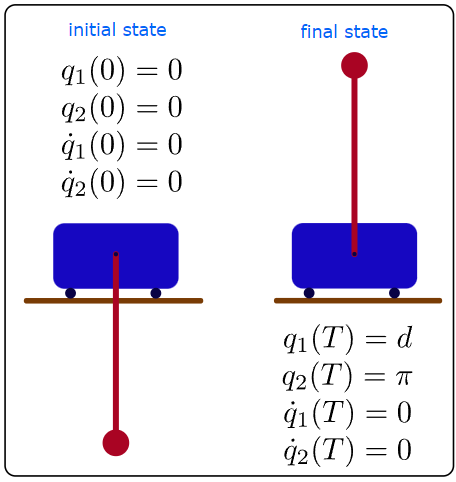

Defining boundary constraints.

In [9]:
# Initial condition
problem.subject_to(q1[0]==x_0[0])  
problem.subject_to(q2[0]==x_0[1])  
problem.subject_to(dq1[0]==x_0[2])  
problem.subject_to(dq2[0]==x_0[3]) 
 
# Final condition
problem.subject_to(q1[-2]==x_f[0])  
problem.subject_to(q2[-2]==x_f[1])  
problem.subject_to(dq1[-2]==x_f[2])  
problem.subject_to(dq2[-2]==x_f[3]) 
 
problem.subject_to(q1[-1]==x_f[0])  
problem.subject_to(q2[-1]==x_f[1])  
problem.subject_to(dq1[-1]==x_f[2])  
problem.subject_to(dq2[-1]==x_f[3])

# Trapaziodal Collocation Method


Trapezoidal collocation works by converting a continuous-time trajectory optimization problem into a nonlinear program. This is done by using trapezoidal quadrature, also know as the trapezoid rule for integration, to convert each continuous aspect
of the problem into a discrete approximation. 

We can collect all of the equations in this section and combine them with the trapezoidal collocation method and write down the cart-pole swing-up problem as a nonlinear program:

our goal is to minimize the objective function which is the integral of
the actuator-effort (control) squared, subject to the collocation constraints

In [10]:
# objective function: trapaziodal Collocation
dt = T/N 
cost = 0
Q = 1
R = 40
for k in range(N-1):
    cost += R*dt*((u[k].T @ u[k]) + (u[k+1].T @ u[k+1]))/2
    cost += Q*dt*(state[:4,k] - x_f[:4]).T @ (state[:4,k] - x_f[:4])

problem.minimize(cost) 

For Trapezoidal Collocation, the collocation constraints are constructed by writing the dynamics in integral form and then **approximating** that integral using Trapezoidal Quadrature. 

This approximation is then applied between every pair of collocation points:


In [11]:
# collocation constraints
for k in range(N):

  # Algebric constraints
  dyn_cons = Q_dyn(state[:,k],u[:,k])
  problem.subject_to(dyn_cons == 0) 
  # Integral Constraints
  hk = dt
  q1_new = q1[k] + hk*(dq1[k+1]+dq1[k])/2
  q2_new = q2[k] + hk*(dq2[k+1]+dq2[k])/2
  dq1_new = dq1[k] + hk*(ddq1[k+1]+ddq1[k])/2
  dq2_new = dq2[k] + hk*(ddq2[k+1]+ddq2[k])/2
  problem.subject_to(q1[k+1] == q1_new) 
  problem.subject_to(q2[k+1] == q2_new) 
  problem.subject_to(dq1[k+1] == dq1_new) 
  problem.subject_to(dq2[k+1] == dq2_new) 

# Initial guess


The cart-pole swing-up problem is a
boundary value problem. We are given the initial and final states, and our task is to compute an optimal trajectory between those two points. An obvious (and simple) initial guess is that the system moves linearly between the initial and final states with zero control effort. This simple guess works well for this problem, despite its failure satisfy the system dynamics

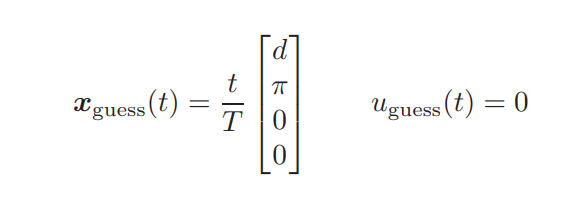

The initial guess for each decision variable in the nonlinear program is then computed at each knot point tk

In [12]:
for k in range(N): 
    tk = k/N
    problem.set_initial(q1[k], x_0[0]*(1-tk) + tk*x_f[0]) 
    problem.set_initial(q2[k], x_0[1]*(1-tk) + tk*x_f[1])
    problem.set_initial(dq1[k], x_0[2]*(1-tk) + tk*x_f[2])
    problem.set_initial(dq2[k], x_0[3]*(1-tk) + tk*x_f[3])
    
    problem.set_initial(ddq1[k], x_0[4]*(1-tk) + tk*x_f[4])
    problem.set_initial(ddq2[k], x_0[5]*(1-tk) + tk*x_f[5])

    problem.set_initial(u[k], 0)

# Solving a problem




solving defined above problem using IPOPT solver, which is a class to solve the NLP program

In [ ]:
# solve NLP
problem.solver("ipopt") # set numerical backend
sol = problem.solve()   # solve defined problem

# Solution


Parsing the solution from `sol`:

In [14]:
q1_opt = sol.value(q1)
q2_opt = sol.value(q2)
dq1_opt = sol.value(dq1)
dq2_opt = sol.value(dq2)

ddq1_opt = sol.value(ddq1)
ddq2_opt = sol.value(ddq2)

u_opt = sol.value(u)

### Plotting the Resulted Position, Angle and Control Trajectory.

Cart orizontal Position:

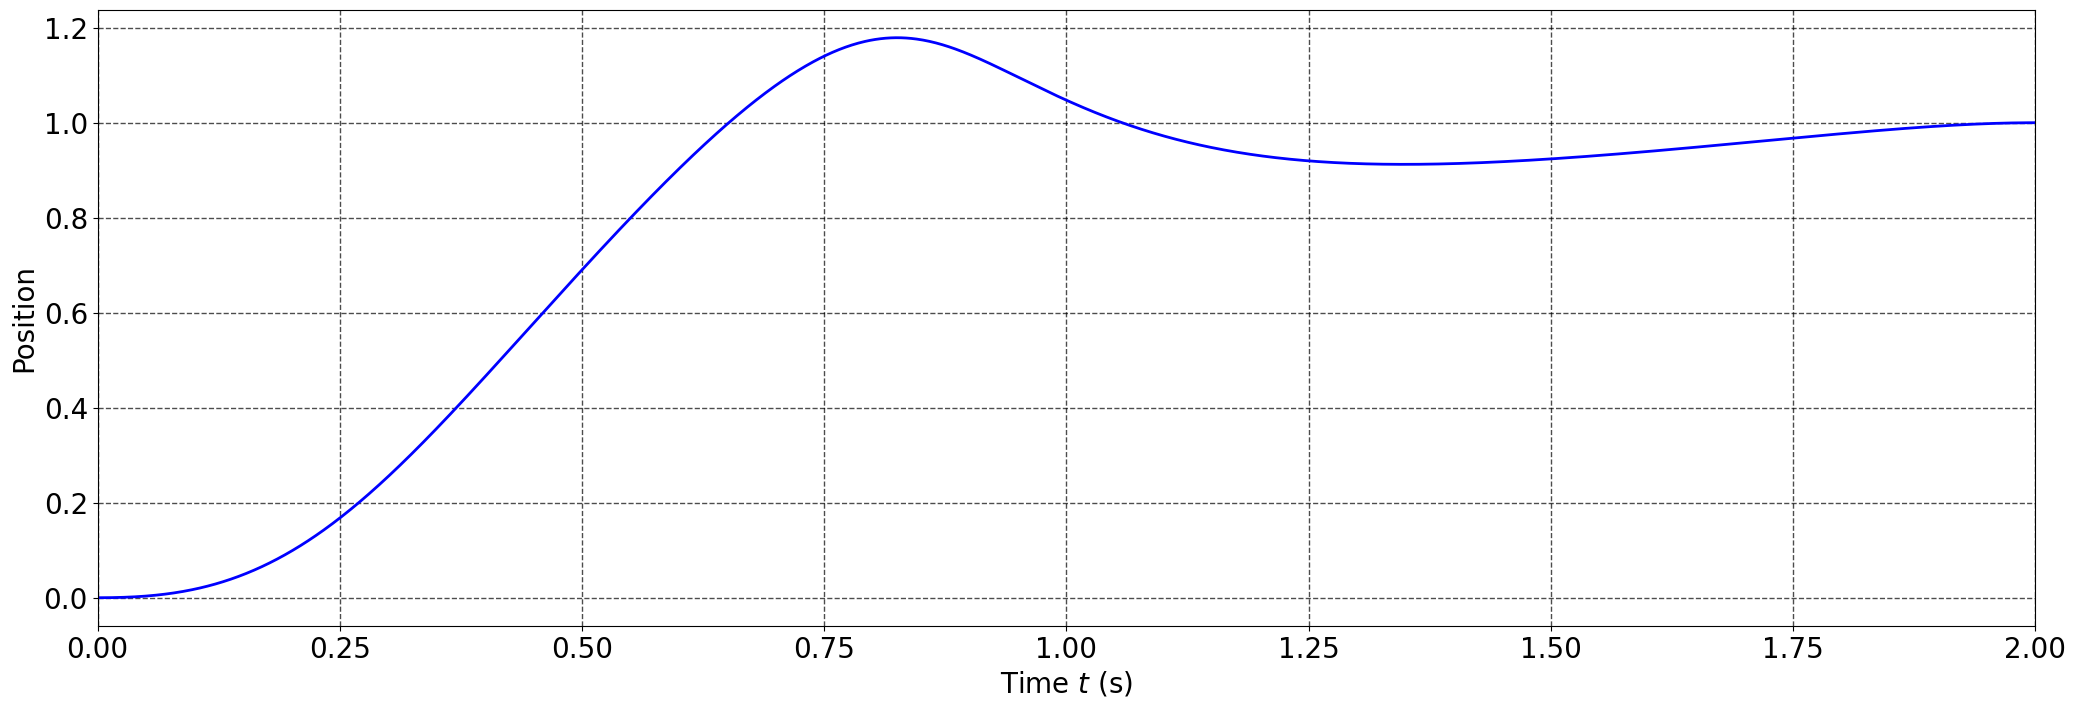

In [15]:
t = linspace(0, T, N+1)
figure(figsize=(25,8))
plot(t, q1_opt,'b', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
# ylim([0,1.5])
xlim([0,2])
ylabel(r'Position')
xlabel(r'Time $t$ (s)')
show()

Pole Angle:

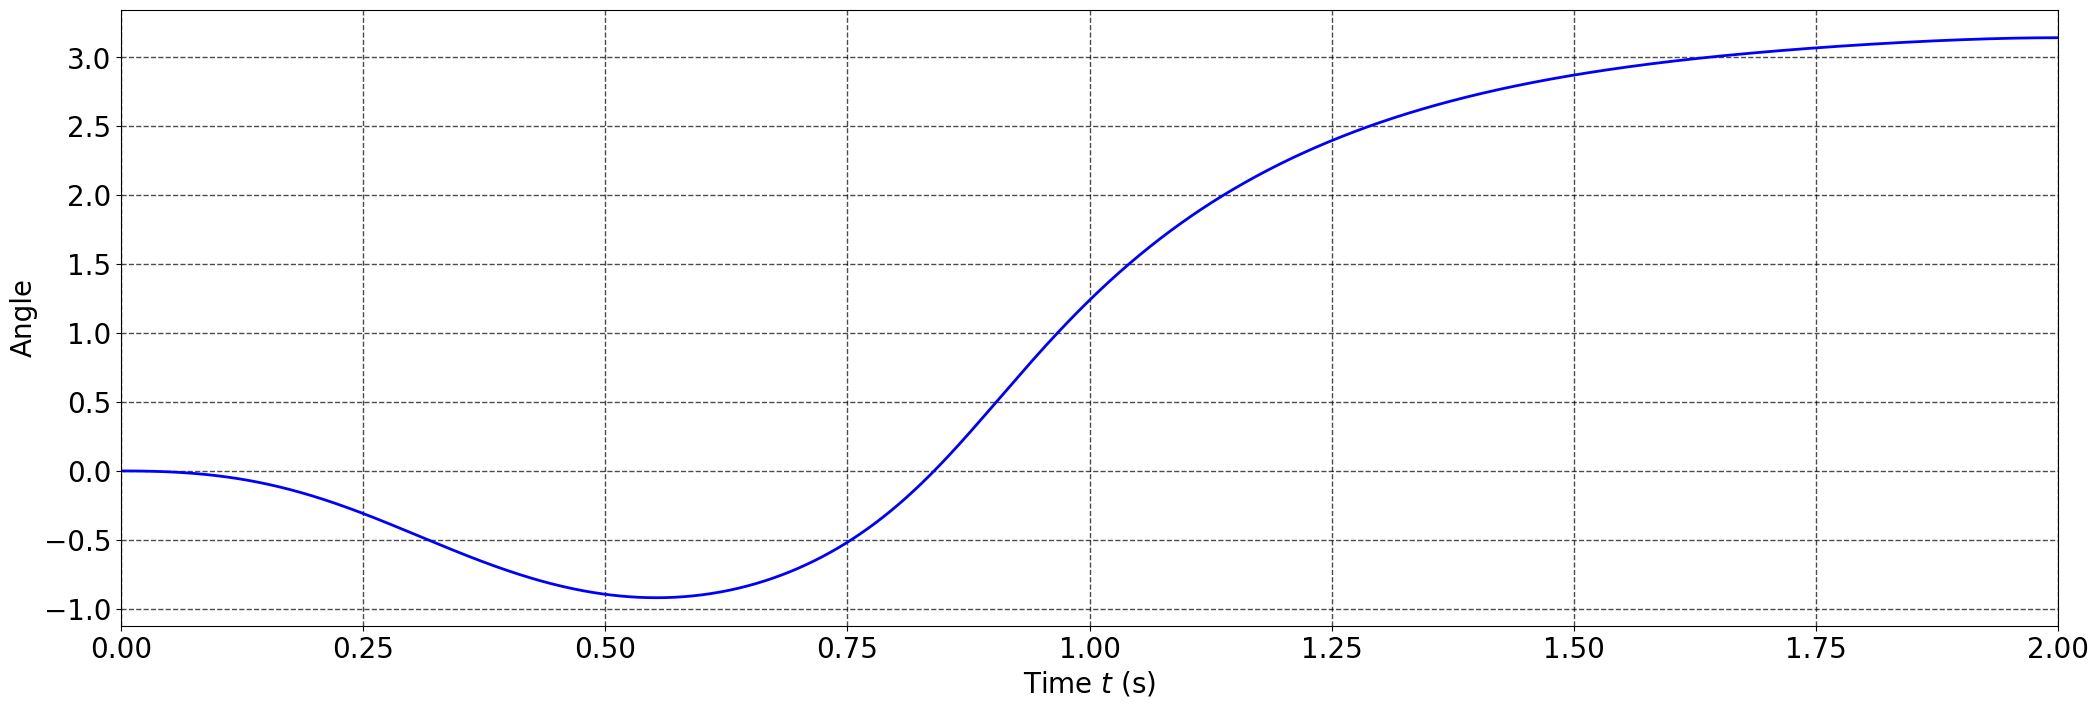

In [16]:
figure(figsize=(25,8))
plot(t, q2_opt,'b', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
# ylim([-2,4])
xlim([0,2])
ylabel(r'Angle')
xlabel(r'Time $t$ (s)')
show()

Control:

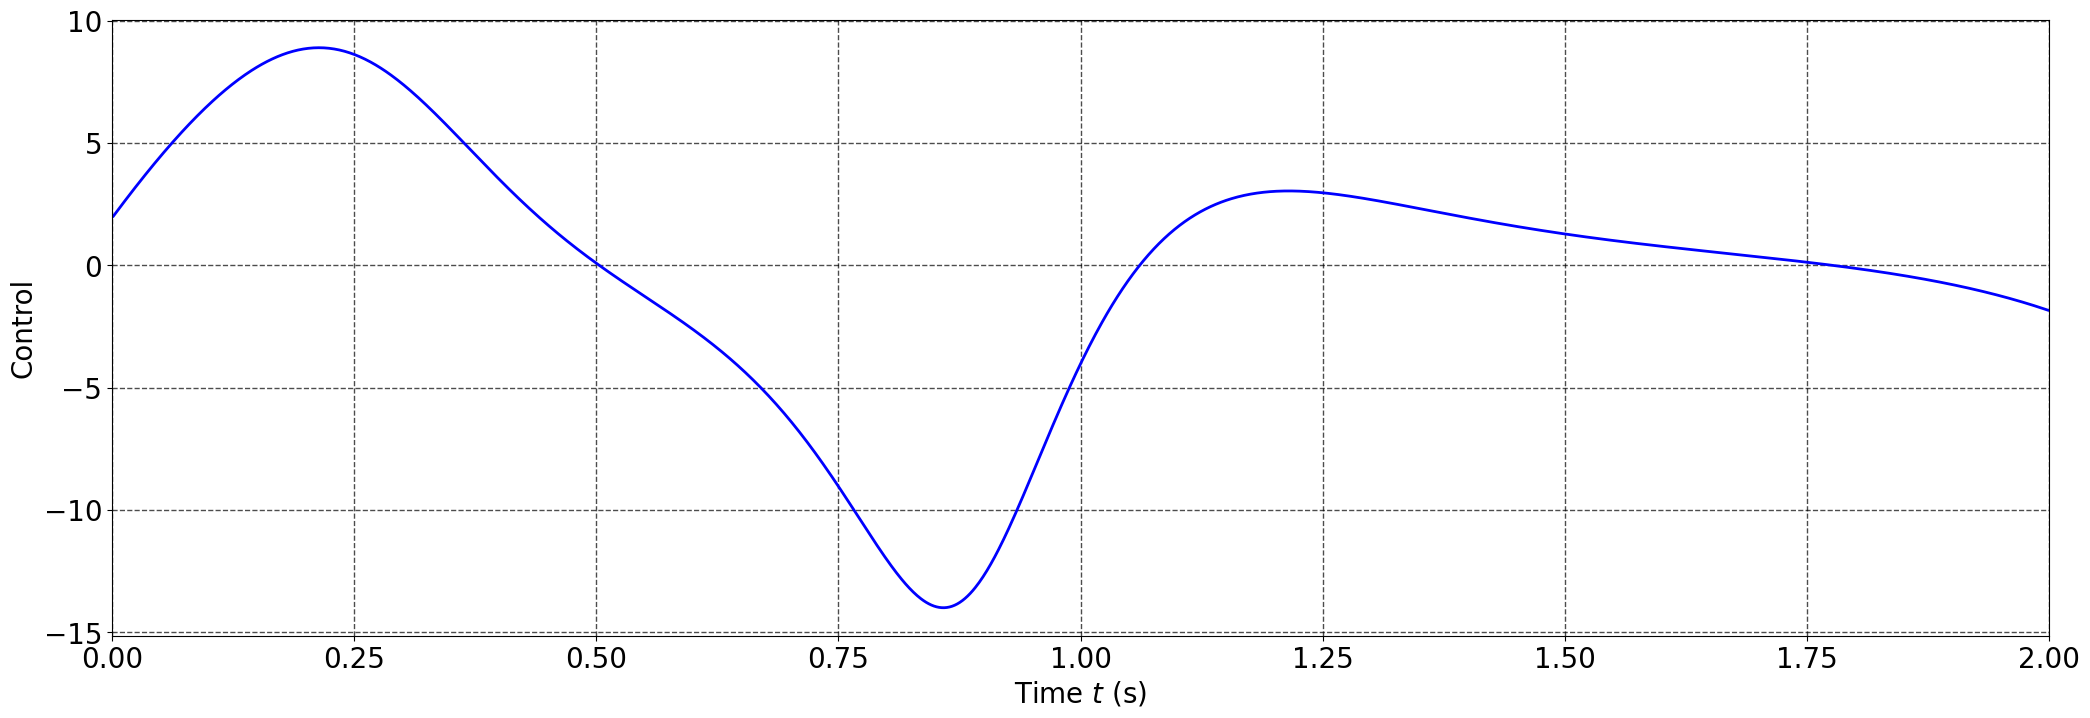

In [17]:
figure(figsize=(25,8))
t = linspace(0, T, N)
plot(t, u_opt,'b', linewidth=2.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
# ylim([-20,12])
xlim([0,2])
ylabel(r'Control')
xlabel(r'Time $t$ (s)')
show()